In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set up the environement of the notebook

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load and visualize the data

In [5]:
x_train_val = np.load('/content/drive/MyDrive/Colab Notebooks/A2NDL/P2/x_train.npy')
y_train_val = np.load('/content/drive/MyDrive/Colab Notebooks/A2NDL/P2/y_train.npy')

In [6]:
labels={0: "Wish",
1: "Another",
2: "Comfortably",
3: "Money",
4: "Breathe",
5: "Time",
6: "Brain",
7: "Echoes",
8: "Wearing",
9: "Sorrow",
10: "Hey",
11: "Shine"}

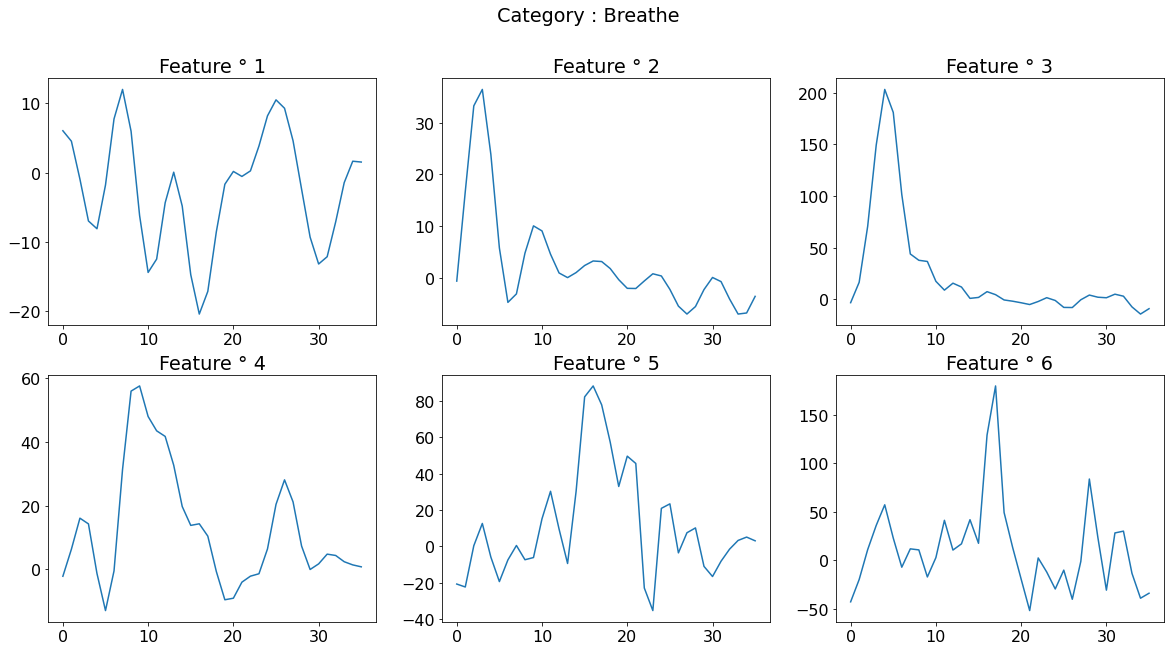

In [7]:
def plot_example(random_index, x,y ):
    example=x[random_index]
    example_label=y[random_index]

    n_points=example.shape[0] # 36
    n_features=example.shape[1] # 6

    counter=0
    fig, axs= plt.subplots(2, 3, figsize=(20,10))
    fig.suptitle('Category : '+labels[example_label])
    for i in range(n_features):
        row= counter//3
        col= counter%3
        example_on_ith_feature=example[:,i]
        axs[row,col].set_title('Feature ° '+str(i+1))
        axs[row,col].plot(example_on_ith_feature)
        counter=counter+1

random_index=np.random.randint(0,2428) 
plot_example(random_index,x_train_val,y_train_val)

In [9]:
# CLASS REPARTITIONS

class_repartitions={"Wish":0,
"Another":0,
"Comfortably":0,
"Money":0,
"Breathe":0,
"Time":0,
"Brain":0,
"Echoes":0,
"Wearing":0,
"Sorrow":0,
"Hey":0,
"Shine":0}

for y in y_train_val:
    label=labels[y]
    class_repartitions[label]=class_repartitions[label]+1
    
S=0
for key in class_repartitions:
    S=S+class_repartitions[key]

print("TOTAL : ",S)
print(class_repartitions)

TOTAL :  2429
{'Wish': 34, 'Another': 123, 'Comfortably': 270, 'Money': 381, 'Breathe': 62, 'Time': 153, 'Brain': 313, 'Echoes': 68, 'Wearing': 120, 'Sorrow': 777, 'Hey': 77, 'Shine': 51}


# Preprocess the data

In [10]:
from sklearn.preprocessing import RobustScaler

x_train_scale = np.copy(x_train_val)

for i in range(x_train_val.shape[2]):
  transformer = RobustScaler().fit(x_train_val[:,:,i])
  x_train_scale[:,:,i] = transformer.transform(x_train_val[:,:,i])

# Model and training

In [ ]:
# SPLITING
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train_scale, y_train_val, test_size=0.2, random_state=seed, stratify=y_train_val)

In [ ]:
# Encoding target variable
y_train_categorical = tfk.utils.to_categorical(y_train)
y_val_categorical = tfk.utils.to_categorical(y_val)

In [ ]:
x_train.shape, x_val.shape, y_train_categorical.shape, y_val_categorical.shape

((1943, 36, 6), (486, 36, 6), (1943, 12), (486, 12))

In [ ]:
input_shape = x_train.shape[1:]
output_shape = y_train_categorical.shape[1:]
batch_size = 32
epochs = 200

In [ ]:
def build_1DCNN_classifier(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout1 = tfkl.Dropout(0.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout1)
    dropout2 = tfkl.Dropout(0.2, seed=seed)(classifier)
    output_layer = tfkl.Dense(output_shape[0], activation='softmax')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 36, 256)           4864      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 18, 256)          0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 18, 256)           196864    
                                                                 
 global_average_pooling1d_5   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 256)               0     

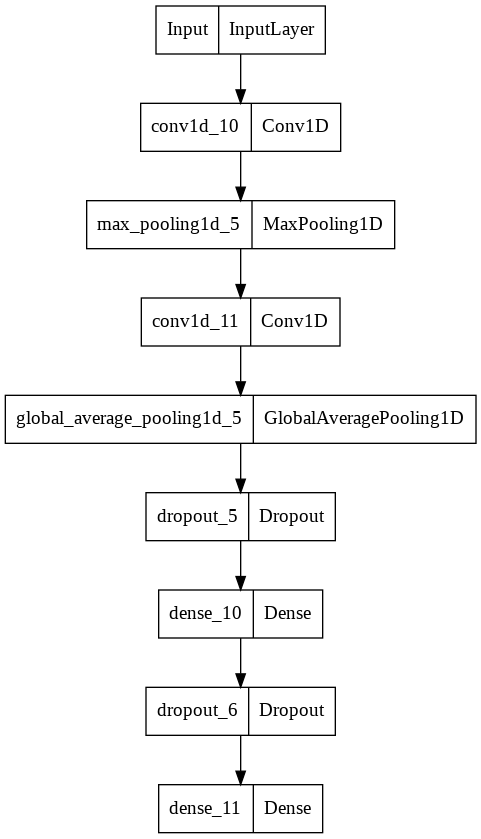

In [ ]:
model = build_1DCNN_classifier(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train_categorical,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val, y_val_categorical),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]   
).history

Epoch 1/200
61/61 [==============================] - 3s 41ms/step - loss: 4.2289 - accuracy: 0.2115 - val_loss: 2.5846 - val_accuracy: 0.3210 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 2s 38ms/step - loss: 3.4278 - accuracy: 0.3052 - val_loss: 2.3144 - val_accuracy: 0.3519 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 2s 38ms/step - loss: 2.7104 - accuracy: 0.3520 - val_loss: 2.2583 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 2s 38ms/step - loss: 2.2583 - accuracy: 0.3659 - val_loss: 1.8366 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 2s 37ms/step - loss: 2.0084 - accuracy: 0.3870 - val_loss: 1.8590 - val_accuracy: 0.3745 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 2s 38ms/step - loss: 2.0062 - accuracy: 0.3896 - val_loss: 1.6968 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 7/200
61/61 [==============================] - 2s 38ms/step - lo

In [ ]:
predictions = model.predict(x_val)
predictions.shape

16/16 [==============================] - 0s 8ms/step


(486, 12)

Accuracy: 0.7551
Precision: 0.727
Recall: 0.6141
F1: 0.6501


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


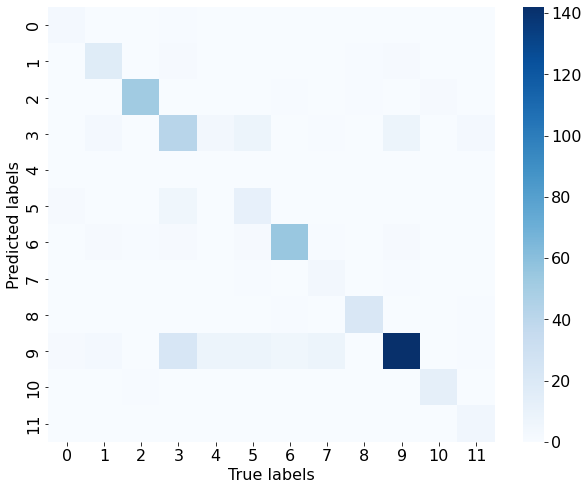

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(labels.keys()), yticklabels=list(labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/A2NDL/P2
%mkdir -p saved_model
model.save('saved_model/CONV1D_V1')

/content/drive/MyDrive/Colab Notebooks/A2NDL/P2
